# Build HDF5 Container Input for GCN from Methylation Data

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn
%matplotlib inline

## 1. Load Sample Methylation Matrix

In [2]:
meth_all_samples = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_sample_matrix.tsv', sep='\t')
meth_all_samples.head()

,Symbol,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|support_promoter,TCGA-AB-2995-03A-01D-0741-05|laml|mean_beta_value_gene,TCGA-AB-2995-03A-01D-0741-05|laml|support_gene,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_promoter,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_gene,TCGA-2E-A9G8-01A-11D-A409-05|ucec|support_gene,TCGA-AB-2967-03A-01D-0742-05|laml|mean_beta_value_promoter,...,TCGA-AF-A56K-01A-32D-A39G-05|read|mean_beta_value_gene,TCGA-AF-A56K-01A-32D-A39G-05|read|support_gene,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|support_promoter,TCGA-A6-6652-01A-11D-1772-05|coad|mean_beta_value_gene,TCGA-A6-6652-01A-11D-1772-05|coad|support_gene,TCGA-AA-3982-01A-02D-1020-05|coad|mean_beta_value_promoter,TCGA-AA-3982-01A-02D-1020-05|coad|support_promoter,TCGA-AA-3982-01A-02D-1020-05|coad|mean_beta_value_gene,TCGA-AA-3982-01A-02D-1020-05|coad|support_gene
0,NOC2L,0.376182,5.0,0.610813,144.0,0.206396,5.0,0.520351,144.0,0.440170,...,0.600294,144.0,0.274885,5.0,0.659646,144.0,0.014763,1.0,0.341992,4.0
1,KLHL17,0.505613,5.0,0.718080,56.0,0.329464,5.0,0.627770,56.0,0.326996,...,0.664157,56.0,0.471816,5.0,0.667767,56.0,NaN,0.0,NaN,0.0
2,HES4,0.637643,4.0,0.249460,7.0,0.476490,4.0,0.217699,7.0,0.670134,...,0.223460,7.0,0.731515,4.0,0.285746,7.0,NaN,0.0,0.026147,1.0
3,ISG15,0.528665,9.0,0.582890,249.0,0.468090,9.0,0.419662,249.0,0.526321,...,0.521213,249.0,0.471958,9.0,0.575165,248.0,0.022389,1.0,0.014798,5.0
4,AGRN,0.656114,12.0,0.652157,512.0,0.499254,12.0,0.491089,512.0,0.689007,...,0.601281,512.0,0.569931,11.0,0.652280,511.0,NaN,0.0,0.139998,10.0


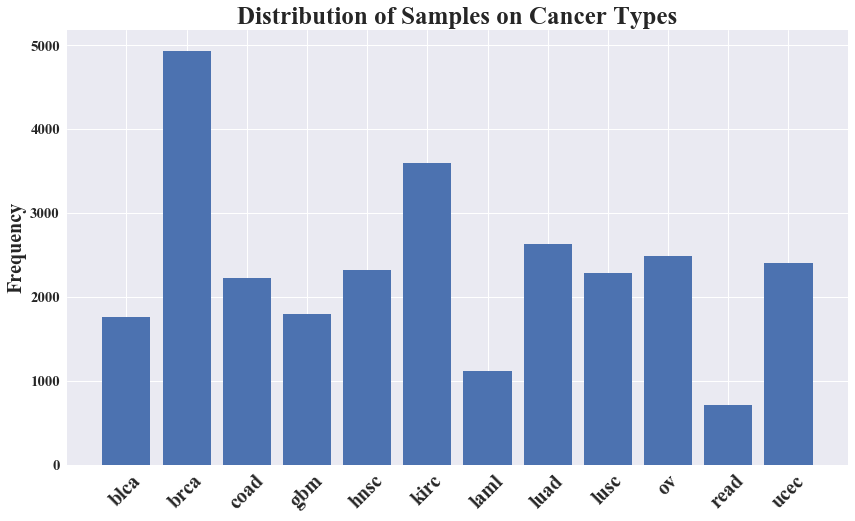

In [26]:
c_types = [n.split('|')[1] for n in meth_all_samples.columns[1:]]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
ax = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation='45', fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)

## 2. Mean Samples Across Cancer Types

In [27]:
meth_t = meth_all_samples.T
meth_t['cancer_type'] = [None] + [i[1] for i in meth_t.index.str.split('|')[1:]]

ValueError: Length of values does not match length of index

In [38]:
meth_per_ctype = meth_t.groupby('cancer_type').mean().T

DataError: No numeric types to aggregate

In [ ]:
meth_per_ctype.head()